This notebook demonstrates the implementation of the Q-AGREL reinforcement leraning algorithm developed by [Pozzi, Bohté & Roelfsema, 2018](https://arxiv.org/abs/1811.01768).


It is a 'biologically plausible' supervised learning method because it doesn't require the backpropogation of error gradients. Instead, it uses a global reward error signal and an attention-like feedback network to allow for weight updates to learn supervised tasks. This notebook goes through a conceptual replication of their work.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits

from hebbnets.utils import softmax
from hebbnets.networks import MultilayerQAGRELNetwork

In [2]:
# Load MNIST dataset
num_categories = 10
data_X, data_Y = load_digits(
    n_class=num_categories,
    return_X_y=True)

data_X -= np.percentile(data_X.ravel(), 1)
data_X /= np.percentile(data_X.ravel(), 99)

train_idx = [(idx % 5) > 0 for idx in range(len(data_Y))]
test_idx = [(idx % 5) == 0 for idx in range(len(data_Y))]

In [3]:
# Initialize network with 2 hidden layers
input_layer_size = data_X.shape[1]
nodes_per_layer = [300, 100, num_categories]

qagrel_network = MultilayerQAGRELNetwork(
    input_layer_size,
    nodes_per_layer,
    act_type='relu',
)

In [4]:
# Train it for a few epochs

qagrel_network.train(
    list(zip(data_X[train_idx, :], data_Y[train_idx])),
    num_epochs=10
)

In [5]:
# Get predicted labels on test dataset

results = []
for x_in, y_targ in zip(data_X[test_idx, :], data_Y[test_idx]):
    qagrel_network.propogate_input(x_in)
    score = softmax(qagrel_network.layers[-1].activation, temp=0.1).ravel()
    results.append(
        {
            'true_categ': y_targ,
            'pred_categ': np.argmax(score),
            'is_corr': np.argmax(score) == y_targ,
            'score': score[y_targ]
        }
    )

df_results = pd.DataFrame(results)

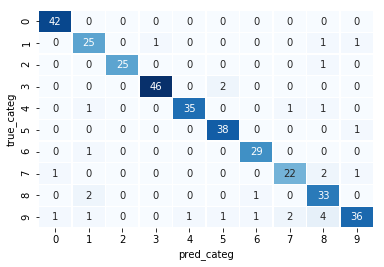

In [6]:
# Check out the confusion matrix!

df_confmat = pd.pivot_table(
    df_results,
    index='true_categ',
    columns='pred_categ',
    values='is_corr',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(df_confmat, linewidths=0.2, cmap='Blues', annot=True, cbar=False)